In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import numpy as np
import pandas as pd

traffic_df = pd.read_csv('/content/gdrive/MyDrive/CIC-Darknet/darknet_log.csv')
traffic_df.shape

(141481, 80)

### Drop Columns

In [3]:
drop_columns = [2, 5, 8, 9, 10, 12, 13, 14, 15, 18, 19, 23, 24, 25, 28, 32, 33, 34, 35, 37, 40, 41, 42, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 76]
traffic_df.drop(traffic_df.columns[drop_columns], axis=1 ,inplace=True)
traffic_df.head()

,Src Port,Dst Port,Flow Duration,Total Fwd Packet,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Max,...,Packet Length Std,PSH Flag Count,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,FWD Init Win Bytes,Bwd Init Win Bytes,Idle Mean,Idle Max,Idle Min,target
0,57158,443,229,1,0,0,0.000,0.000000,9.075050,229,...,0.00,0,0,0,1892,1047,0.000000,0.000000,0.000000,0
1,57159,443,407,1,0,0,0.000,0.000000,8.500048,407,...,0.00,0,0,0,1987,1047,0.000000,0.000000,0.000000,0
2,57160,443,431,1,0,0,0.000,0.000000,8.442765,431,...,0.00,0,0,0,2049,1047,0.000000,0.000000,0.000000,0
3,49134,443,359,1,0,0,0.000,0.000000,8.625515,359,...,0.00,0,0,0,2008,1047,0.000000,0.000000,0.000000,0
4,34697,19305,10778451,591,64530,6659,3.148,8.795696,4.531983,78158,...,4.06,659,659,6605,1382,2320,34.901863,34.901863,34.901863,0


### Data Split

In [4]:
from sklearn.model_selection import train_test_split

y_traffic_df = traffic_df['target']
X_traffic_df = traffic_df.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_traffic_df, y_traffic_df, stratify=y_traffic_df, test_size=0.4, random_state=11)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(84888, 29) (84888,)
(56593, 29) (56593,)


In [5]:
X_vali, X_test, y_vali, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=11)
print(X_vali.shape, y_vali.shape)
print(X_test.shape, y_test.shape)

(28296, 29) (28296,)
(28297, 29) (28297,)


In [6]:
label_name = ['benign_Audio-Streaming', 'benign_Browsing', 'benign_Chat', 'benign_Email', 'benign_File-Transfer', 'benign_P2P', 'benign_VOIP', 'benign_Video-Streaming', 'darknet_Audio-Streaming', 'darknet_Browsing', 'darknet_Chat', 'darknet_Email', 'darknet_File-Transfer', 'darknet_P2P', 'darknet_VOIP', 'darknet_Video-Streaming']
len(label_name)

16

### Model Train / Validation

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

lgbm_wrapper = LGBMClassifier(random_state=11, n_estimators=500, boost_from_average=False)
lgbm_wrapper.fit(X_train, y_train)
lgbm_pred = lgbm_wrapper.predict(X_vali)

print('{0} 정확도:{1:.4f}'.format(lgbm_wrapper.__class__.__name__, accuracy_score(y_vali, lgbm_pred)))
print(confusion_matrix(y_vali, lgbm_pred), '\n')
print(classification_report(y_vali, lgbm_pred, target_names=label_name), '\n')

LGBMClassifier 정확도:0.9072
[[ 629   31    4    1   19   13    1  227   26    0    1    0    1    0
     0    1]
 [   5 6386    2    0   74    3    0   37    0    0    0    0    1    0
     0    1]
 [   3   16  989  206    8    3   99   17    6    0    1    1    2    0
    35    0]
 [   0    1  392  622    4    0   63    0    2    0    0    2   10    0
    16    0]
 [  12  194   19    5 1416    6    3   51    1    0    0    0    1    0
     2    2]
 [   0    2    0    0    0 9657    0    0    1    0    0    0    0    0
     0    0]
 [   0    0  142   70    1    0  199    0    1    0    0    0    1    0
     6    0]
 [ 237  133    3    1   49    3    0 1215   32    0    1    0    4    0
     1    1]
 [  20    0    1    1    0    0    0   23 2590    0    7    0    6    0
     0    9]
 [   0    0    0    3    0    0    0    0    1   48    0    0    0    0
     0    1]
 [   1    0    0    0    0    0    0    9    8    1  886    0    2    0
     0    1]
 [   0    2    0    3    1    0    0   

### Feature Importance

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def print_feature_importances(model):
    columns = traffic_df.drop('target', axis=1, inplace=False).columns
    
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=columns)
    
    ftr_importances = ftr_importances.sort_values(ascending=False)[:29]
    
    #feautre importance를 column 별로 시각화하기
    plt.figure(figsize=(8, 6))
    plt.title('{0} Feature Importances'.format(model.__class__.__name__))
    sns.barplot(x=ftr_importances, y=ftr_importances.index)
    plt.show()

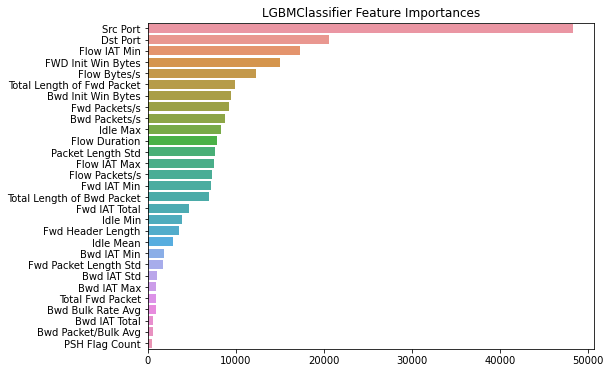

In [9]:
print_feature_importances(lgbm_wrapper)